In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

import pickle
import re
from pathlib import Path

data_dir = Path(globals()['_dh'][0]).parent / 'data'
figure_dir = data_dir / 'figures'
figure_dir.mkdir(exist_ok=True)

plt.style.use('seaborn-bright')
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

In [84]:
with (data_dir / 'throughput_pairs.pickle').open('rb') as f:
    data = pickle.load(f)

In [85]:
records = []
for k, v in data.items():
    src_region, dst_region, num_threads = k
    throughput_recieved_gbps = v["end"]["sum_sent"]["bits_per_second"] / 1e9
    throughput_sent_gbps = v["end"]["sum_received"]["bits_per_second"] / 1e9
    records.append(dict(src_region=src_region, dst_region=dst_region, num_threads=num_threads, throughput_recieved_gbps=throughput_recieved_gbps, throughput_sent_gbps=throughput_sent_gbps))
df = pd.DataFrame(records).sort_values(by=['throughput_recieved_gbps', 'throughput_sent_gbps'])
df

,src_region,dst_region,num_threads,throughput_recieved_gbps,throughput_sent_gbps
37,ap-northeast-1,eu-central-1,128,3.576491,2.917166
23,eu-central-1,ap-northeast-1,128,3.632349,2.947030
11,us-east-1,ap-southeast-1,128,3.785755,3.112169
17,eu-west-1,ap-northeast-1,128,3.796914,3.150103
14,ap-southeast-1,us-east-1,128,3.813290,3.113508
40,ap-northeast-1,eu-west-1,128,3.849088,3.133930
3,us-east-2,ap-southeast-1,128,3.916011,3.191354
48,ap-southeast-1,us-east-2,128,3.937297,3.152877
26,eu-central-1,eu-central-1,128,3.959274,3.341484
7,eu-west-1,ap-southeast-1,128,4.048375,3.353385


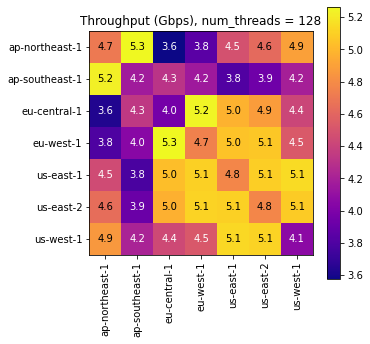

In [86]:
region_list = list(sorted(set(df['src_region'].to_list() + df['dst_region'].to_list())))

def make_throughput_grid(df, region_list):
    recieved_gbps = np.zeros((len(region_list), len(region_list)))
    sent_gbps = np.zeros((len(region_list), len(region_list)))
    for _, row in df.iterrows():
        src_region_idx = region_list.index(row['src_region'])
        dst_region_idx = region_list.index(row['dst_region'])
        recieved_gbps[src_region_idx, dst_region_idx] = row['throughput_recieved_gbps']
        sent_gbps[src_region_idx, dst_region_idx] = row['throughput_sent_gbps']
    return recieved_gbps, sent_gbps

# plot grid of throughputs for each pair of regions on X and Y axis
# only plot rows with highest num_threads
grouped_df = df.groupby(['num_threads'])
for num_threads, group in grouped_df:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    recieved_gbps, sent_gbps = make_throughput_grid(group, region_list)
    ax.imshow(recieved_gbps)
    ax.set_title(f'Throughput (Gbps), num_threads = {num_threads}')
    ax.set_xticks(np.arange(len(region_list)))
    ax.set_yticks(np.arange(len(region_list)))
    ax.set_xticklabels(region_list)
    ax.set_yticklabels(region_list)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for i, row in enumerate(recieved_gbps):
        for j, col in enumerate(row):
            ax.text(j, i, round(col, 1), ha='center', va='center', color='white' if col < recieved_gbps.mean() else 'black')

    # set white background
    fig.patch.set_facecolor('white')

    # pad between subplots
    fig.subplots_adjust(hspace=0.6)

    # colorbar
    cbar = ax.figure.colorbar(ax.images[0], ax=ax)

    fig.savefig(figure_dir / f'throughput_grid_num_threads_{num_threads}.png', dpi=300, bbox_inches='tight')